# Flagging holidays

In this notebook, we will discuss 3 methods to flag holidays in our data:

- Manually
- Using the `holidays` package
- Using pandas

We will use the **online_retail dataset**, which you can obtain following the instructions in the notebook: `02-create-online-retail-II-datasets` in the **01-Create-Datasets** folder.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data and prepare data

In [2]:
# File path:
file = "../Datasets/online_retail_II.xlsx"

# The data is provided as two sheets in a single Excel file.
# Each sheet contains a different time period.
# Load both and join them into a single dataframe
# as shown below:

df = pd.read_excel(file, sheet_name="Year 2009-2010")
# df_2 = pd.read_excel(file, sheet_name="Year 2010-2011")

# df = pd.concat([df_1, df_2])

# Rename columns
df.columns = [
    "invoice",
    "stock_code",
    "description",
    "quantity",
    "invoice_date",
    "price",
    "customer_id",
    "country",
]

# just UK
df = df[df["country"] == "United Kingdom"]

# add revenue variable
df["revenue"] = df["quantity"] * df["price"]

# remove cancelled orders and missing customer ids
df["is_cancelled"] = df["invoice"].apply(lambda x: str(x)[0] == "C")
mask = (~df["customer_id"].isnull()) & (~df["is_cancelled"])

# resample for total daily revenue
df = (
    df.loc[mask, ["invoice_date", "quantity", "revenue"]]
    .resample("D", on="invoice_date")
    .sum()
)

df.head()

,quantity,revenue
invoice_date,,
2009-12-01,21050,37366.32
2009-12-02,25248,45644.67
2009-12-03,47485,66327.53
2009-12-04,18607,31448.44
2009-12-05,4722,9042.36


In [12]:
df.loc["2010-11-22":"2010-11-26"]

,quantity,revenue
invoice_date,,
2010-11-22,14541,27730.36
2010-11-23,22915,46286.36
2010-11-24,23266,40106.34
2010-11-25,36443,66040.90
2010-11-26,11107,20950.99


<AxesSubplot:xlabel='invoice_date'>

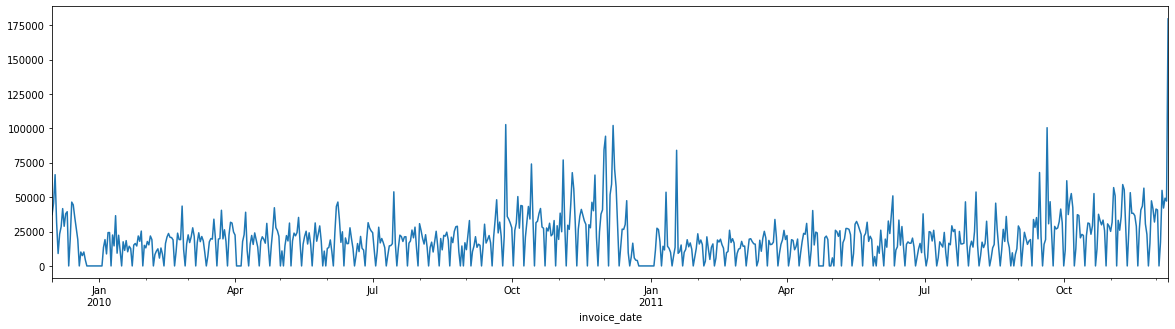

In [3]:
# plot time series

df["revenue"].plot(figsize=(20,5))

## Flag specific dates - manually

First, we create a list with the specific holidays we want to highlight, for example Black Fridays. And then we add an indicator to flag those dates in our dataset.

- Pros: Easy
- Con: We need to enter manually each date, for each year ==> impractical

In [13]:
import datetime

In [22]:
# Black Friday dates in 2010 and 2011
black_friday = [datetime.date(2010, 11, 26), 
                datetime.date(2011, 11, 25)]


# Create dummy variable for Black Friday
df["is_black_friday"] = np.where(df.index.isin(black_friday), 1, 0)

In [23]:
df.loc["2010-11-22":"2010-11-26"]

,quantity,revenue,is_black_friday
invoice_date,,,
2010-11-22,14541,27730.36,0
2010-11-23,22915,46286.36,0
2010-11-24,23266,40106.34,0
2010-11-25,36443,66040.90,0
2010-11-26,11107,20950.99,1


In [20]:
%%timeit
np.where(df.index.isin(black_friday), 1, 0)

130 µs ± 8.41 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
# flag Black Fridays

df["holidays"] = np.where(df.index.isin(black_friday),1,0)

df[df["holidays"]==1]

,quantity,revenue,holidays
invoice_date,,,
2010-11-26,11107,20950.99,1
2011-11-25,25197,22978.56,1


In [7]:
# let's double check that it was Friday

df[df["holidays"]==1].index.weekday

Int64Index([4, 4], dtype='int64', name='invoice_date')

## With the holidays library

- https://pypi.org/project/holidays/
- https://python-holidays.readthedocs.io/en/latest/

**Pros**: contains the holidays from several countries.

In [8]:
import holidays

In [9]:
uk_holidays = holidays.UK()

uk_holidays

holidays.country_holidays('GB', subdiv='UK')

In [10]:
# let's check the holidays available for the UK

for date, name in sorted(holidays.UK(subdiv='UK', years=[2010,2011]).items()):
    print(date, name)

2010-01-01 New Year's Day
2010-01-02 New Year Holiday [Scotland]
2010-01-04 New Year Holiday [Scotland] (Observed)
2010-03-17 St. Patrick's Day [Northern Ireland]
2010-04-02 Good Friday
2010-04-05 Easter Monday [England/Wales/Northern Ireland]
2010-05-03 May Day
2010-05-31 Spring Bank Holiday
2010-07-12 Battle of the Boyne [Northern Ireland]
2010-08-02 Summer Bank Holiday [Scotland]
2010-08-30 Late Summer Bank Holiday [England/Wales/Northern Ireland]
2010-11-30 St. Andrew's Day [Scotland]
2010-12-25 Christmas Day
2010-12-26 Boxing Day
2010-12-27 Christmas Day (Observed)
2010-12-28 Boxing Day (Observed)
2011-01-01 New Year's Day
2011-01-02 New Year Holiday [Scotland]
2011-01-03 New Year's Day (Observed)
2011-01-04 New Year Holiday [Scotland] (Observed)
2011-03-17 St. Patrick's Day [Northern Ireland]
2011-04-22 Good Friday
2011-04-25 Easter Monday [England/Wales/Northern Ireland]
2011-04-29 Wedding of William and Catherine
2011-05-02 May Day
2011-05-30 Spring Bank Holiday
2011-07-12 Batt

In [11]:
# let's capture the dates in a list:

uk_holidays = [items[0] for items in holidays.UK(subdiv='UK', years=[2010,2011]).items()]

uk_holidays

[datetime.date(2010, 1, 1),
 datetime.date(2010, 1, 2),
 datetime.date(2010, 1, 4),
 datetime.date(2010, 3, 17),
 datetime.date(2010, 7, 12),
 datetime.date(2010, 8, 2),
 datetime.date(2010, 11, 30),
 datetime.date(2010, 12, 25),
 datetime.date(2010, 12, 27),
 datetime.date(2010, 4, 2),
 datetime.date(2010, 4, 5),
 datetime.date(2010, 5, 3),
 datetime.date(2010, 5, 31),
 datetime.date(2010, 8, 30),
 datetime.date(2010, 12, 26),
 datetime.date(2010, 12, 28),
 datetime.date(2011, 1, 1),
 datetime.date(2011, 1, 3),
 datetime.date(2011, 1, 2),
 datetime.date(2011, 1, 4),
 datetime.date(2011, 3, 17),
 datetime.date(2011, 7, 12),
 datetime.date(2011, 8, 1),
 datetime.date(2011, 11, 30),
 datetime.date(2011, 12, 25),
 datetime.date(2011, 12, 27),
 datetime.date(2011, 4, 22),
 datetime.date(2011, 4, 25),
 datetime.date(2011, 5, 2),
 datetime.date(2011, 5, 30),
 datetime.date(2011, 8, 29),
 datetime.date(2011, 12, 26),
 datetime.date(2011, 4, 29)]

In [12]:
# flag holidays

df["holidays"] = np.where(df.index.isin(uk_holidays),1,0)

df[df["holidays"]==1]

,quantity,revenue,holidays
invoice_date,,,
2010-01-01,0,0.00,1
2010-01-02,0,0.00,1
2010-01-04,10601,13450.54,1
2010-03-17,13010,19504.10,1
2010-04-02,0,0.00,1
2010-04-05,0,0.00,1
2010-05-03,0,0.00,1
2010-05-31,0,0.00,1
2010-07-12,8234,14555.73,1


Check for other countries in the documentation: https://python-holidays.readthedocs.io/en/latest/index.html#available-countries

## With pandas

Pandas supports the US Federal Holidays by default. For any other country, we need to create a special calendar. 

Let's create a calendar for the UK.

### Rules

Most holidays occur on a certain date, but are observed on a different day if they fall on a weekend. With this information, we can create rules to automatically assign the holidays to the correct date for every year.

**Pandas supports the following default rules:**

- nearest_workday ==> move Saturday to Friday and Sunday to Monday
- sunday_to_monday ==> move Sunday to following Monday
- next_monday_or_tuesday ==> move Saturday to Monday and Sunday/Monday to Tuesday
- previous_friday ==> move Saturday and Sunday to previous Friday
- next_monday ==> move Saturday and Sunday to following Monday

It also allows us to speficy a day in a month, for example, first Monday or 3rd Friday through the MO, TU, WE, TH, FR, SA, SU functions.

In [13]:
from pandas.tseries.holiday import (
    Holiday,
    AbstractHolidayCalendar, # provides all the necessary methods to return a list of holidays
    nearest_workday, # rule
    GoodFriday,
    EasterMonday,
    MO, # rule
    FR, # rule
)

In [14]:
# let's create our calendar

class UKHolidays(AbstractHolidayCalendar):
    rules = [
        GoodFriday,
        
        EasterMonday,
        
        Holiday("New Year's Day", month=1, day=1),
        
        Holiday("May Day", month=5, day=1, offset=pd.DateOffset(
            weekday=MO(1))),  # first monday
        
        Holiday("Spring Bank Holiday", month=5, day=31,
                offset=pd.DateOffset(weekday=MO(-1))),  # last monday
        
        Holiday("Black Fridays", month=11, day=25,
                offset=pd.DateOffset(weekday=FR(-1))), # third friday
        
        Holiday("Company's birthday", month=8,
                day=29, observance=nearest_workday),
        
    ]

For more information about how MO, TU, WE, TH, FR, SA and SU work, check the library [relativedelta](https://dateutil.readthedocs.io/en/stable/relativedelta.html#dateutil.relativedelta.relativedelta).

**weekday:**

One of the weekday instances (MO, TU, etc) available in the
relativedelta module. These instances may receive a parameter N,
specifying the Nth weekday, which could be positive or negative
(like MO(+1) or MO(-2)). Not specifying it is the same as specifying
+1. You can also use an integer, where 0=MO. This argument is always
relative e.g. if the calculated date is already Monday, using MO(1)
or MO(-1) won't change the day. To effectively make it absolute, use
it in combination with the day argument (e.g. day=1, MO(1) for first
Monday of the month).

In [15]:
# set up the calendar

cal = UKHolidays()

In [16]:
cal.rules

[Holiday: Good Friday (month=1, day=1, offset=[<Easter>, <-2 * Days>]),
 Holiday: Easter Monday (month=1, day=1, offset=[<Easter>, <Day>]),
 Holiday: New Year's Day (month=1, day=1, ),
 Holiday: May Day (month=5, day=1, offset=<DateOffset: weekday=MO(+1)>),
 Holiday: Spring Bank Holiday (month=5, day=31, offset=<DateOffset: weekday=MO(-1)>),
 Holiday: Black Fridays (month=11, day=25, offset=<DateOffset: weekday=FR(-1)>),
 Holiday: Company's birthday (month=8, day=29, observance=<function nearest_workday at 0x00000227772B95A0>)]

In [17]:
# find the holiday dates in a certain period of time

uk_holidays = cal.holidays(datetime.datetime(2010, 11, 1), datetime.datetime(2012, 3, 31))

uk_holidays

DatetimeIndex(['2010-11-19', '2011-01-01', '2011-04-22', '2011-04-25',
               '2011-05-02', '2011-05-30', '2011-08-29', '2011-11-25',
               '2012-01-01'],
              dtype='datetime64[ns]', freq=None)

In [18]:
# flag holidays

df["holidays"] = np.where(df.index.isin(uk_holidays),1,0)

df[df["holidays"]==1]

,quantity,revenue,holidays
invoice_date,,,
2010-11-19,18837,30229.20,1
2011-01-01,0,0.00,1
2011-04-22,0,0.00,1
2011-04-25,0,0.00,1
2011-05-02,0,0.00,1
2011-05-30,0,0.00,1
2011-08-29,0,0.00,1
2011-11-25,25197,22978.56,1


I have to say, I am not amazed by the documentation on this topic. These are the available links:

- source code: https://github.com/pandas-dev/pandas/blob/main/pandas/tseries/holiday.py
- docs: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html?highlight=holiday#holidays-holiday-calendars

## Default US calendar

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar

In [20]:
cal = USFederalHolidayCalendar()

cal.rules

[Holiday: New Year's Day (month=1, day=1, observance=<function nearest_workday at 0x00000227772B95A0>),
 Holiday: Birthday of Martin Luther King, Jr. (month=1, day=1, offset=<DateOffset: weekday=MO(+3)>),
 Holiday: Washington’s Birthday (month=2, day=1, offset=<DateOffset: weekday=MO(+3)>),
 Holiday: Memorial Day (month=5, day=31, offset=<DateOffset: weekday=MO(-1)>),
 Holiday: Juneteenth National Independence Day (month=6, day=19, observance=<function nearest_workday at 0x00000227772B95A0>),
 Holiday: Independence Day (month=7, day=4, observance=<function nearest_workday at 0x00000227772B95A0>),
 Holiday: Labor Day (month=9, day=1, offset=<DateOffset: weekday=MO(+1)>),
 Holiday: Columbus Day (month=10, day=1, offset=<DateOffset: weekday=MO(+2)>),
 Holiday: Veterans Day (month=11, day=11, observance=<function nearest_workday at 0x00000227772B95A0>),
 Holiday: Thanksgiving Day (month=11, day=1, offset=<DateOffset: weekday=TH(+4)>),
 Holiday: Christmas Day (month=12, day=25, observance=<